# DOG-BREED

In [1]:
a[5][5]=0

NameError: name 'a' is not defined

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import pandas as pd
import torch.nn.functional as F

In [2]:
import os
import matplotlib.pylab as plt
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import numpy as np
from sklearn import preprocessing

In [3]:
train=pd.read_csv('dataset/train.csv')
len(train['Labels'].unique())  #No of breeds 120

120

In [4]:
le=preprocessing.LabelEncoder()
train['Target']=le.fit_transform(train['Labels'])  #inverse_transform to get the label back


In [5]:
class Dataset(Dataset): #can include a validation dataset by using train=true and updating the code accordingly
    def __init__(self,transform=None,training=True,prediction=False):
            folder='dataset\\train'
            train_paths=[os.path.join(folder,file) for file in train['Filename']]
            self.X=train_paths
            y=torch.tensor(train['Target'].values)
            self.y=y.view(-1).long()
            self.transform=transform
            print(self.y)
            if prediction:
                self.len=len(self.X)
            else:
                if training:
                    self.X=self.X[0:13500]
                    self.y=self.y[0:13500]
                    self.len=len(self.X)
                else:
                    self.X=self.X[13500:]
                    self.y=self.y[13500:]
                    self.len=len(self.X)
    
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        image=Image.open(self.X[idx]).convert('RGB')
        label=self.y[idx]
        
        if self.transform:
            image=self.transform(image)
        
        return image,label
        

tensor([ 86, 101,  77,  ...,  50,   1,   1])


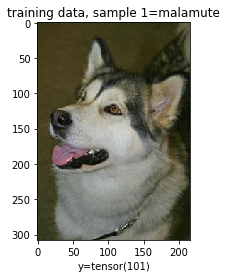

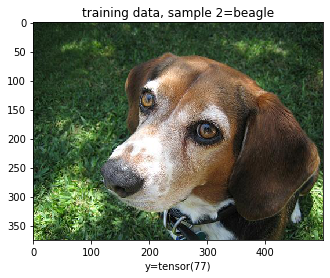

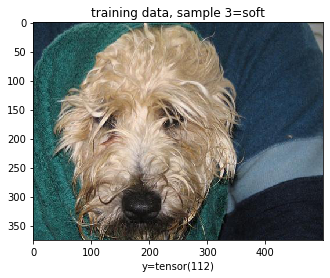

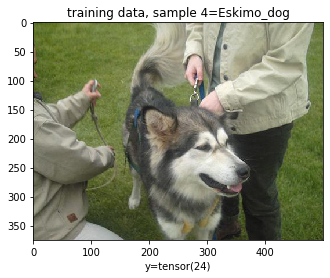

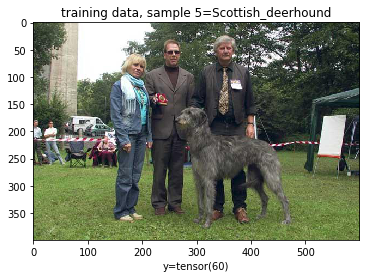

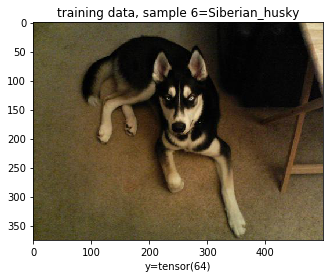

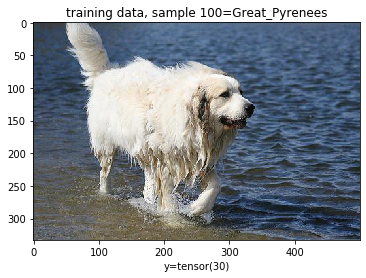

In [6]:
dataset=Dataset()
samples=[1,2,3,4,5,6,100]
for sample  in samples:
    plt.imshow(dataset[sample][0])
    plt.xlabel("y="+str(dataset[sample][1]))
    plt.title("training data, sample {}={}".format(int(sample),train['Labels'][sample]))
    plt.show()

In [7]:
transform=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]  )
    
])

In [8]:
torch.cuda.empty_cache()

In [10]:
#alexnet torchvision sucks model from scratch
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1 )        
        # convolutional layer (sees 112x112x16 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        # convolutional layer (sees 56x56x32 image tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        # convolutional layer (sees 28x28x64 image tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding = 1)        
        # convolutional layer (sees 14x14x128 image tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding = 1 )
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)
        
        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)
        
        # linear layer (256 * 7 * 7 -> 512)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        # linear layer (256 * 7 * 7 -> n_classes (133))
        self.fc2 = nn.Linear(512, 120)
        
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv_bn2(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv_bn3(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.conv_bn4(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.conv_bn5(x)
        x = self.pool(F.relu(self.conv5(x)))
        x = self.conv_bn6(x)
        
        # flatten image input
        x = x.view(-1, 256 * 7 * 7)        
        # add dropout layer
        x = self.dropout(x)
        # add second hidden layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:

alexnet= models.densenet161(pretrained=True)
for param in alexnet.parameters():
    param.requires_grad = False
num_ftrs = alexnet.classifier.in_features
alexnet.classifier = nn.Linear(num_ftrs, 120)
device=torch.device("cuda:0")
alexnet =alexnet.to(device)

In [13]:
alexnet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [14]:
#alexnet.classifier[6]=nn.Linear(4096,120)

In [10]:
alexnet=alexnet.to(device)

In [11]:
dataset_train=Dataset(transform=transform,training=True)
dataset_val=Dataset(transform=transform,training=False)

tensor([ 86, 101,  77,  ...,  50,   1,   1])
tensor([ 86, 101,  77,  ...,  50,   1,   1])


In [15]:
data_loader=DataLoader(dataset=dataset_train,batch_size=20) #more batch_size could fail
validation_loader=DataLoader(dataset=dataset_val,batch_size=20)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam([param for param in alexnet.parameters() if param.requires_grad],lr=0.001)

In [18]:
n_epochs=5
accuracy_list=[]
loss_list=[]
loss_list=[]
n_test=len(dataset_val)
def train_model(n_epochs):
    epoch_completed=0
    for epoch in range(n_epochs):
        for x,y in data_loader:
            alexnet.train()
            optimizer.zero_grad()
            x=x.to(device)
            y=y.to(device)
            z=alexnet(x)
            loss=criterion(z,y)
            loss.backward()
            optimizer.step()
            print("batch_done")
        correct=0
        for x_test,y_test in validation_loader:
            alexnet.eval()
            x_test=x_test.to(device)
            y_test=y_test.to(device)
            z=alexnet(x_test)
            _,yhat=torch.max(z.data,1)
            correct += (yhat == y_test).sum().item()
        accuracy=correct/n_test
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)
        epoch_completed+=1
        print(f"Epochs completed {epoch_completed}")
            

In [19]:
train_model(n_epochs)

batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done

batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done

batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done

batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done

batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done

In [20]:
accuracy_list

[0.864293659621802,
 0.8731924360400445,
 0.8809788654060067,
 0.8743047830923248,
 0.8798665183537263]

In [12]:
total_loader=DataLoader(dataset=Dataset(transform=transform,training=False,prediction=True),batch_size=20)

tensor([ 86, 101,  77,  ...,  50,   1,   1])


In [13]:
def train_predict(n_epochs):
    for x,y in total_loader:
            alexnet.train()
            optimizer.zero_grad()
            x=x.to(device)
            y=y.to(device)
            z=alexnet(x)
            loss=criterion(z,y)
            loss.backward()
            optimizer.step()
            print("batch_done")

In [16]:
train_predict(10)

batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done
batch_done

In [15]:
torch.save(alexnet,'C:\\Users\\thake\\Desktop\\progamming\\Competitons\\Dogbreed\\model.pth')
#testing

In [17]:
alexnet.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [18]:
#total 6181 images for testing
test_1=Image.open('dataset\\train\\2_train.jpg')
test_1=transform(test_1)
batch_1=torch.unsqueeze(test_1,0)
batch_1=batch_1.to(device)

out=alexnet(batch_1)

_, index = torch.max(out.data, 1)
 
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
 
print(_,index, percentage[index[0]].item())

tensor([0.3377], device='cuda:0') tensor([101], device='cuda:0') 69.48115539550781


In [19]:
le.inverse_transform([101])[0]

'malamute'

In [20]:
#test_submission
df_pred=pd.DataFrame()
df_pred['Filename']=[None]*6182
df_pred['Labels']=[None]*6182
for i in range(1,6182):
    df_pred['Filename'][i]=f'{i}_test.jpg'
    test=Image.open(f'dataset\\test\\{i}_test.jpg')
    test=transform(test)
    batch=torch.unsqueeze(test,0)
    batch=batch.to(device)
    out=alexnet(batch)
    _,index=torch.max(out.data,1)
    label=le.inverse_transform([int(index)])[0]
    df_pred['Labels'][i]=label

In [21]:
df_pred.drop(0,inplace=True)
df_pred.to_csv('submit_pred.csv',index=False)

In [22]:
df.shape

NameError: name 'df' is not defined

In [23]:
df_pred.tail()

,Filename,Labels
6177,6177_test.jpg,Mexican_hairless
6178,6178_test.jpg,bloodhound
6179,6179_test.jpg,borzoi
6180,6180_test.jpg,cairn
6181,6181_test.jpg,French_bulldog


In [21]:
train.head()

,Filename,Labels,Target
0,1_train.jpg,chow,86
1,2_train.jpg,malamute,101
2,3_train.jpg,beagle,77
3,4_train.jpg,soft,112
4,5_train.jpg,Eskimo_dog,24
